In [4]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import cProfile
from time import time
from datetime import datetime
import numpy as np
import seaborn as sns
import collections
import ast
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind

# Research Questions : Did education impact Michelle Wei's ability to play in LPGA ? What are some key parameters that impacted a player's average score ? (Use M.W. as the example)

# Data Collection

## Gather Michelle Wei's data from LPGA website using beautifulsoup and request module
## Store the data into CSV files

## Game level data ( Yearly)

In [2]:
# LPGA Parser for individual's historical game record - raw data (each game)
model_list_2 = []
end_year = 2023
year_list = list(range(2002,end_year))
for year in year_list:
    link_to_parse= f"https://www.lpga.com/players/michelle-wie/88106/results?filters={year}&archive="
    if BeautifulSoup(requests.get(link_to_parse).content, 'html.parser').find_all(class_="table") == []:
            #If html table is empty, no data for that player in a specific year
        pass
    else:
        player_df = pd.read_html(link_to_parse)[0].droplevel(0, axis=1) 
        for i in range(0, len(player_df.to_numpy())):
            temp_row = []
            for j in range(0, len(player_df.to_numpy()[i])):
                temp_row.append(player_df.to_numpy()[i][j])
            model_list_2.append(temp_row)
df = pd.DataFrame(model_list_2)
df.columns =['Date','Tournament Name', '1','2','3','4','Total','Final POS','TOT Strokes','TOT Rounds','Score AVG','Official Money']
df.to_csv("player_michelle_wei_historical_LPGA_data.csv")

## Yearly summary data

In [3]:
# LPGA parser for individual's historical game record - summary data (year summary)
list_of_df = []
for year in year_list:
    link_to_parse = f"https://www.lpga.com/players/michelle-wie/88106/stats?filters={year}"
    pandas_table = pd.read_html(link_to_parse)[0].T
    pandas_table.columns = pandas_table.loc['Performance'].tolist()
    pandas_table.reset_index(inplace = True)
    pandas_table = pandas_table.drop(0)
    pandas_table = pandas_table.drop(columns=['index'])
    pandas_table = pandas_table.set_axis(['Year to Date', 'Ranking'], axis=0)
    pandas_table['Year'] = year
    list_of_df.append(pandas_table)

combined_df = pd.concat(list_of_df)
combined_df = combined_df.sort_index()
year_to_date_df = combined_df.loc['Year to Date']
ranking_df = combined_df.loc['Ranking']
year_to_date_df.to_csv("michelle_wei_year_to_date.csv")
ranking_df.to_csv("michelle_wei_ranking.csv")

# Data Wrangling 

## Find the times when MW is studying at Stanford

In [5]:
Stanford_start_time = "09/01/2007"
Stanford_end_time = "06/17/2012"
Stanford_start_time = datetime.strptime(Stanford_start_time, "%m/%d/%Y")
Stanford_end_time = datetime.strptime(Stanford_end_time, "%m/%d/%Y")

In [6]:
game_level_df = pd.read_csv("player_michelle_wei_historical_LPGA_data.csv")
#Convert Date column into datetime formate
game_level_df['Date']= pd.to_datetime(game_level_df['Date'])
#Sort the games by date in ascending order
game_level_df.sort_values(by = "Date", ascending=True)
#Remove Score AVG = 0 entries
game_level_df = game_level_df[game_level_df['Score AVG'] != 0]
#Drop unnamed column
game_level_df.drop(["Unnamed: 0"], axis = 1, inplace = True)

## Print out the dataframe

In [7]:
game_level_df

,Date,Tournament Name,1,2,3,4,Total,Final POS,TOT Strokes,TOT Rounds,Score AVG,Official Money
0,2002-08-02,Wendy's Championship for Children at Tartan Fi...,77 (+5),75 (+3),-,-,152 (+8),CUT,152,2,76.000,$0.00
1,2002-05-16,Asahi Ryokuken International Championship at M...,81 (+10),75 (+4),-,-,156 (+14),CUT,156,2,78.000,$0.00
2,2002-02-28,LPGA Takefuji Classic,72 (+2),74 (+4),-,-,146 (+6),CUT,146,2,73.000,$0.00
3,2003-10-31,CJ Nine Bridges Classic Presented By Sports Today,85 (+13),78 (+6),70 (-2),-,233 (+17),69,233,3,77.667,$0.00
4,2003-09-26,Safeway Classic Presented by Pepsi,69 (-3),72 (E),73 (+1),-,214 (-2),28T,214,3,71.333,$0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
277,2021-04-21,HUGEL-AIR PREMIA LA Open,70 (-1),77 (+6),-,-,147 (+5),CUT,147,2,73.500,$0.00
278,2021-04-01,ANA Inspiration,70 (-2),79 (+7),-,-,149 (+5),CUT,149,2,74.500,$0.00
279,2021-03-25,Kia Classic,81 (+9),74 (+2),-,-,155 (+11),CUT,155,2,77.500,$0.00
280,2022-06-02,U.S. Women's Open presented by ProMedica,73 (+2),74 (+3),-,-,147 (+5),CUT,147,2,73.500,$0.00


## Split MW's time into 3 sub categories 
## 1 represents the time before she joined Stanford
## 2 represents the time when she was at Stanford
## 3 represents the time after she graduated from Stanford

In [8]:
def categorize(row):  
    if pd.Timedelta(row['Date'] - Stanford_end_time).days > 0:
        return 3
    elif pd.Timedelta(row['Date'] - Stanford_start_time).days < 0 :
        return 1
    elif(pd.Timedelta(row['Date'] -  Stanford_start_time).days) > 0 :
        return 2

In [9]:
game_level_df['History'] = game_level_df.apply(lambda row: categorize(row), axis=1)

game_level_df.groupby(pd.Grouper(key='History', axis=0)).median()

In [17]:
game_level_df.groupby(pd.Grouper(key='History', axis=0)).mean()

,TOT Strokes,TOT Rounds,Score AVG
History,,,
1,232.973684,3.236842,72.548263
2,237.690141,3.309859,72.136155
3,236.895062,3.308642,72.014920


In [11]:
game_level_df.groupby(pd.Grouper(key='History', axis=0)).count()

,Date,Tournament Name,1,2,3,4,Total,Final POS,TOT Strokes,TOT Rounds,Score AVG,Official Money
History,,,,,,,,,,,,
1,38,38,38,38,38,38,38,38,38,38,38,38
2,71,71,71,71,71,71,71,71,71,71,71,71
3,162,162,162,162,162,162,162,162,162,162,162,162


## After data wrangling, the data shows that during her time at Stanford (2) , her score average was not higher than her other times (1, 3). Additionally, her average total rounds increased to a 3.3 compared to 3.23 before she joined Stanford. This indicates that she was able to play a few more rounds per tournament on average while she is still studying.  If we look at the number of events played during her different times, the number of events played gradually increased. This is a clear evidence that she can handle both school and golf.

# Read in summary data

In [24]:
def p2f(x):
    return float(x.strip('%'))/100

In [25]:
MW = pd.read_csv("michelle_wei_year_to_date.csv")
MW = MW.sort_values("Year")
MW.drop(['Unnamed: 0'], axis=1, inplace=True)
MW['Driving Accuracy'] = MW['Driving Accuracy'].str.rstrip('%').astype('float') / 100.0
MW['Greens in Regulation'] = MW['Greens in Regulation'].str.rstrip('%').astype('float') / 100.0
MW['Sand Saves'] = MW['Sand Saves'].str.rstrip('%').astype('float') / 100.0

In [26]:
MW= MW[MW['Average Driving Distance'] != 0]
MW.reset_index(drop=True, inplace = True)
#Convert Year column into datetime formate
MW['Year']= pd.to_datetime(MW['Year'], format='%Y')

# Plots for Scoring Average and Total Strokes by year

<AxesSubplot:title={'center':'Scoring Average by year'}, xlabel='Date'>

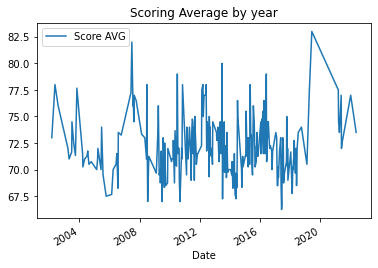

In [27]:
game_level_df.plot('Date','Score AVG', title="Scoring Average by year")

<AxesSubplot:title={'center':'Total Storkes by year'}, xlabel='Date'>

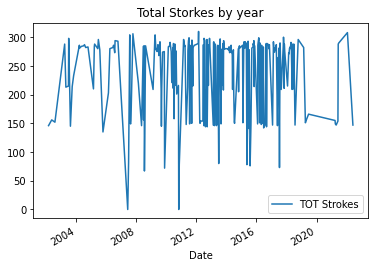

In [28]:
game_level_df.plot('Date','TOT Strokes', title = "Total Storkes by year")

In [29]:
def categorize(row):  
    if pd.Timedelta(row['Year'] - Stanford_end_time).days > 0:
        return 3
    elif pd.Timedelta(row['Year'] - Stanford_start_time).days < 0 :
        return 1
    elif(pd.Timedelta(row['Year'] -  Stanford_start_time).days) > 0 :
        return 2

In [30]:
MW['History'] = MW.apply(lambda row: categorize(row), axis=1)

## Generate Boxplots for better visualizations on some key golf performance comparisons during different times

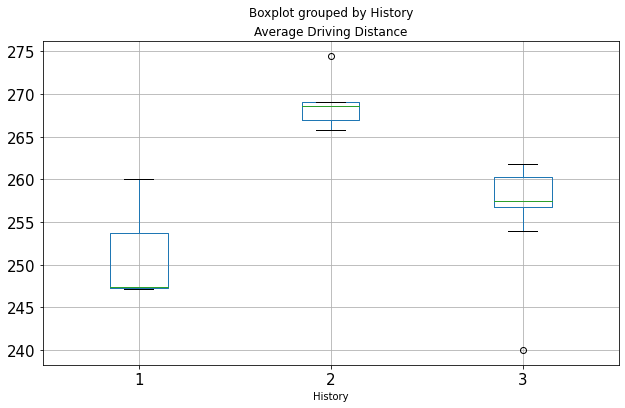

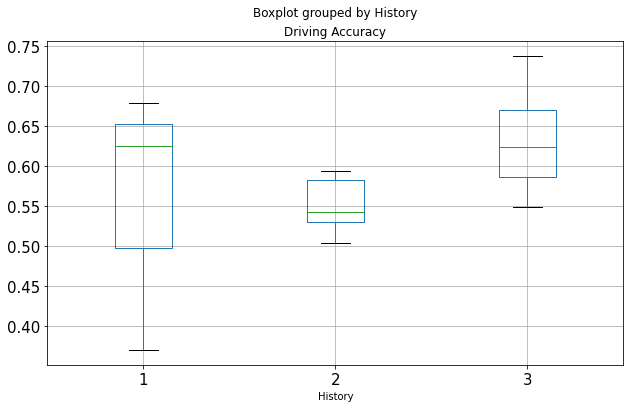

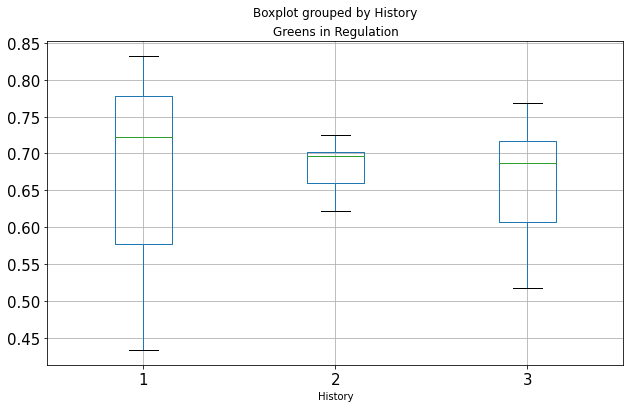

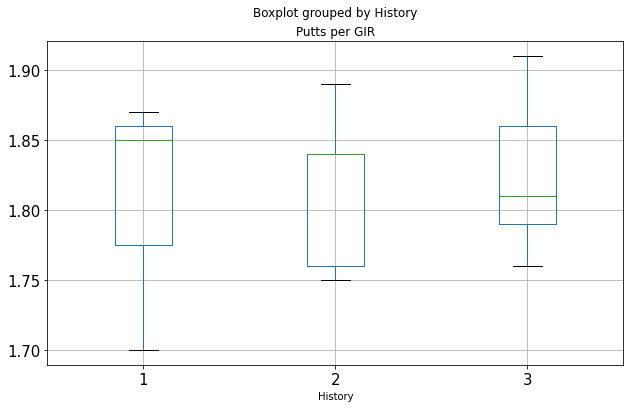

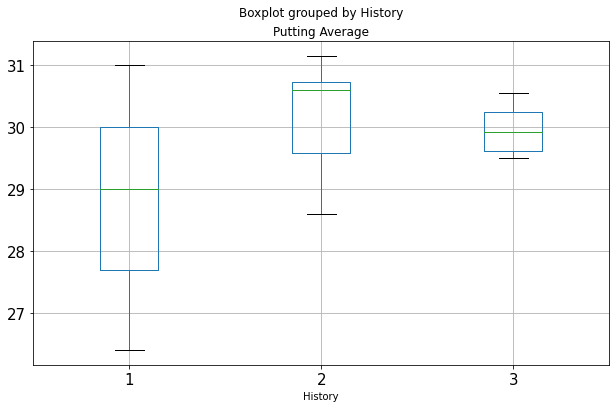

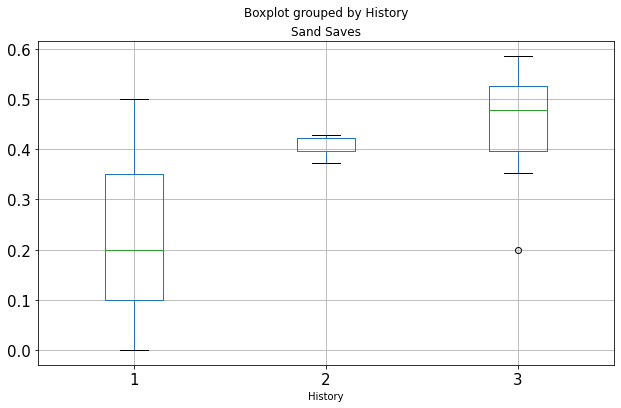

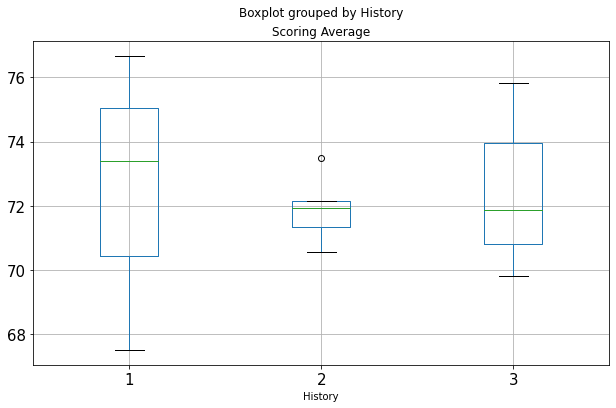

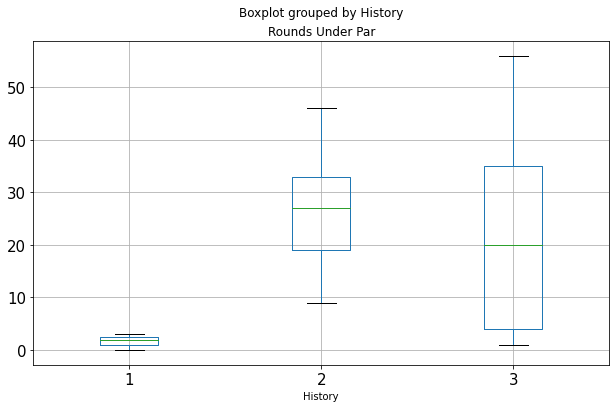

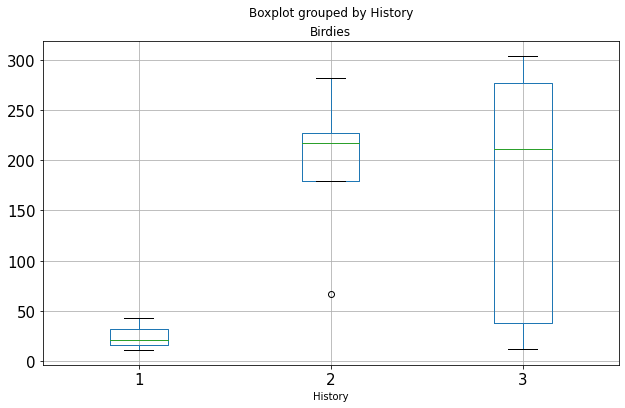

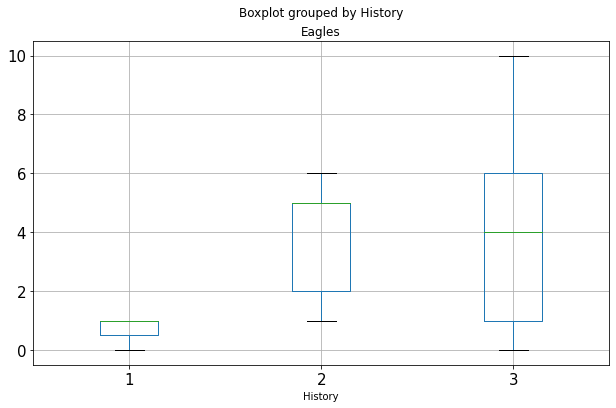

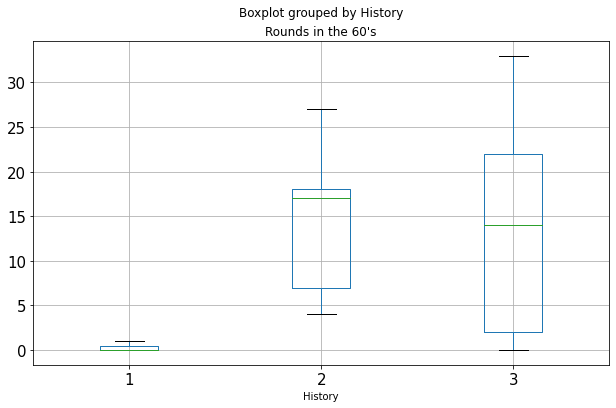

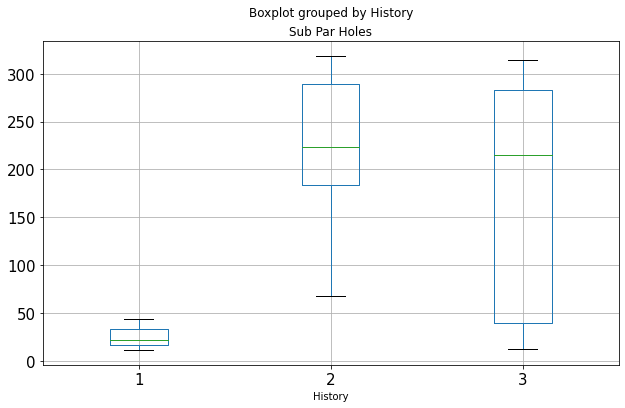

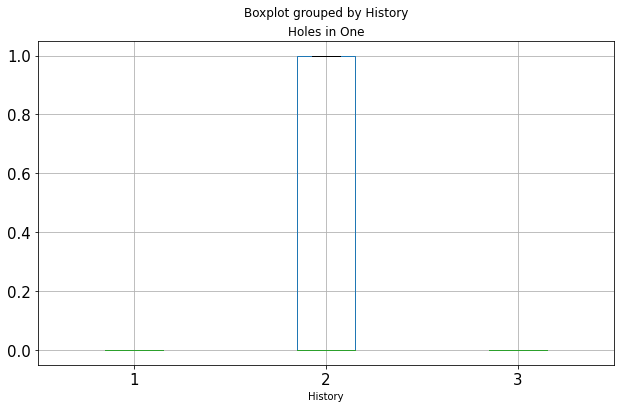

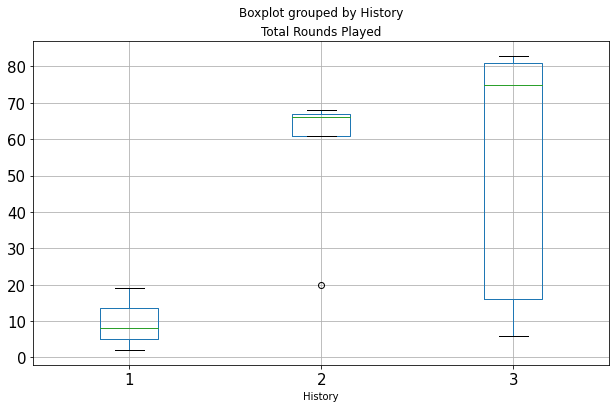

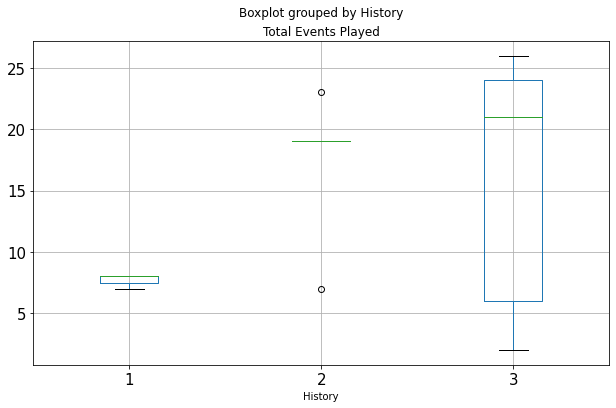

In [40]:
valid_plots = []
attributes_to_be_plotted = ["Average Driving Distance", 'Driving Accuracy',
       'Greens in Regulation', 'Putts per GIR', 'Putting Average',
       'Sand Saves', 'Scoring Average', 'Rounds Under Par', 'Birdies',
       'Eagles', "Rounds in the 60's", 'Sub Par Holes', 'Holes in One',
       'Total Rounds Played', 'Total Events Played']
for i in MW.columns:
    try:
        if i in attributes_to_be_plotted:
            valid_plots.append(MW.boxplot(column=[i],by='History', fontsize = 15, figsize = [10,6]))
        else:
            
            pass
    except:
        continue

## Perform Sample T Test on Average Driving Distance

In [39]:
print(ttest_ind(MW[MW['History']==1]['Average Driving Distance'], MW[MW['History']==2]['Average Driving Distance']))
print(ttest_ind(MW[MW['History']==2]['Average Driving Distance'], MW[MW['History']==3]['Average Driving Distance']))


Ttest_indResult(statistic=-4.740933021045971, pvalue=0.00318836315487906)
Ttest_indResult(statistic=3.893951977071066, pvalue=0.002133298709939889)


## Combining the table results and plots above, sample T-test was run as an additional evidence to prove that the result is statistically significant on the average diriving distance before she attended Stanford and after she joined Stanford. In conclusion, higher education did not impact her ability to play as a professional player.

# Next, I am trying to answer the 2nd research question by looking at yearly summary data and its correlation matrix

# Correlation study and Scatter plots

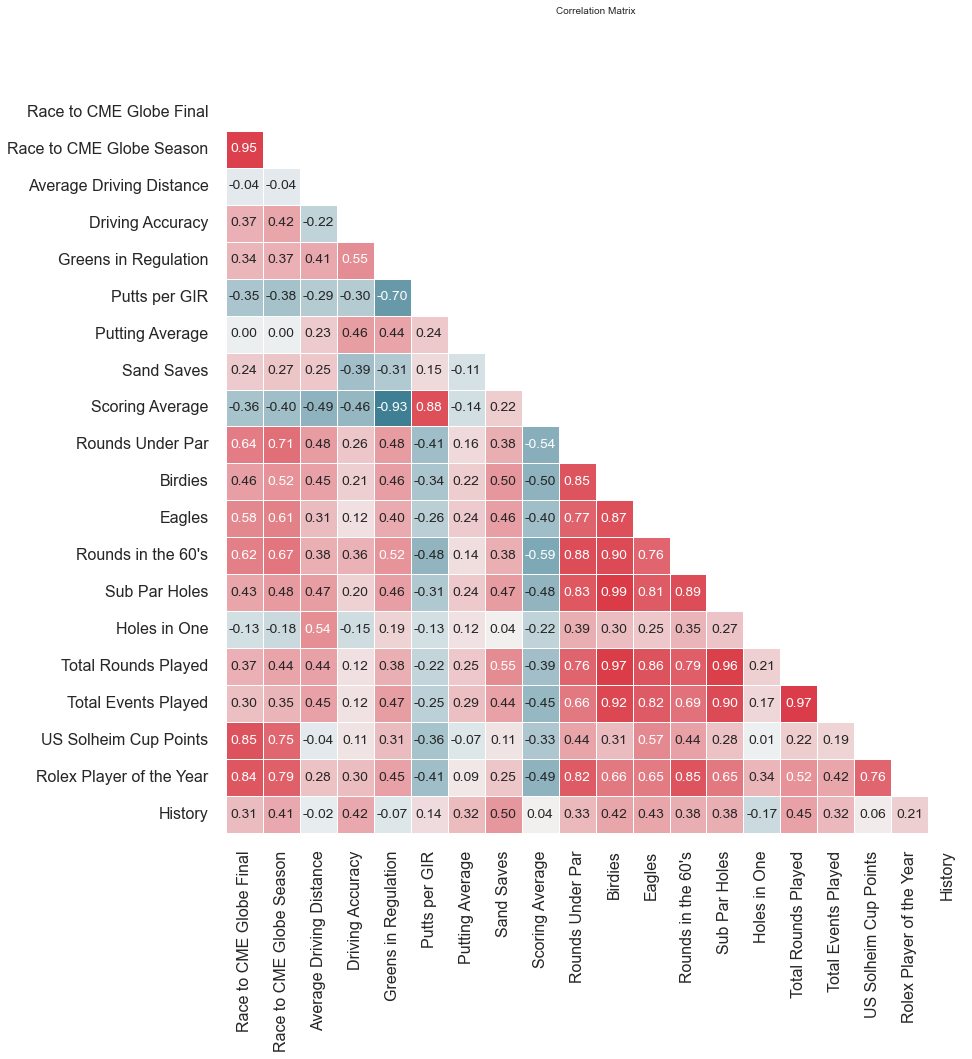

In [52]:
corr = MW.corr()
fig, ax1 = plt.subplots(1,1, figsize = (26.6,15))
sns.set(font_scale = 1.15)
plt.style.use('seaborn-poster')
sns.set_style('whitegrid')
plt.suptitle('Correlation Matrix', size  = 10, ha = 'center')

sns.heatmap(corr, square = True, annot = True, linewidths = .5, cmap = sns.diverging_palette(220, 10, as_cmap = True), cbar = False, mask = np.triu(corr), fmt='.2f', ax = ax1)
# sns.heatmap(corr[['Average Driving Distance']].sort_values(by = ['Average Driving Distance'], ascending=False), cbar = False, annot_kws={"size": 16},vmin=-1, cmap = sns.diverging_palette(220, 10, as_cmap = True), annot = True, ax = ax2)

plt.tight_layout(pad = 1)
plt.subplots_adjust(top = .9)
plt.show()

## Plotting the correlation matrix against all recorded metrics in the yearly summary data. 
## I am particularly interested in seeing what impacts scoring average. Therefore, I plotted scoring average vs all other parameters. The result is as shown below.

In [56]:
def custom_scatter_plot(df, y, x_idx, plots_per_row):
    sns.set(font_scale = 1.25)
    plt.style.use('seaborn-poster')
    
    counter = 0
    
    for feature in x_idx:
        plt.figure(np.floor_divide(counter, plots_per_row), figsize = (30,6))
        plt.subplot(1 ,plots_per_row, np.mod(counter, plots_per_row) +1)
        sns.scatterplot(x = df[feature], y = df[y].values, hue = df[feature], label = 'medium', palette= 'husl')
        plt.legend(loc = 'best', prop={'size': 11})
        counter+= 1

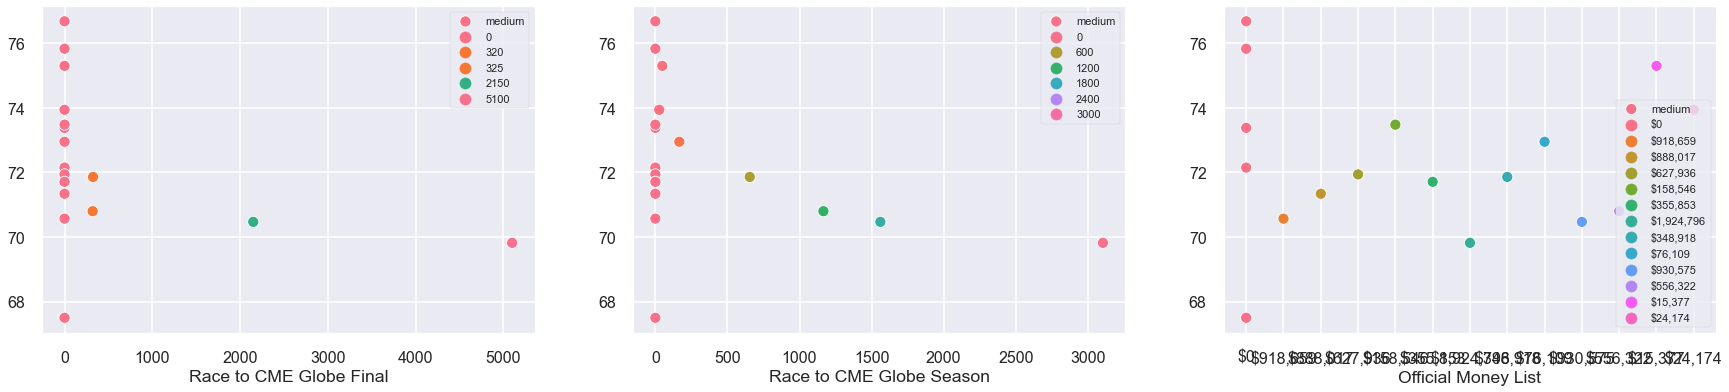

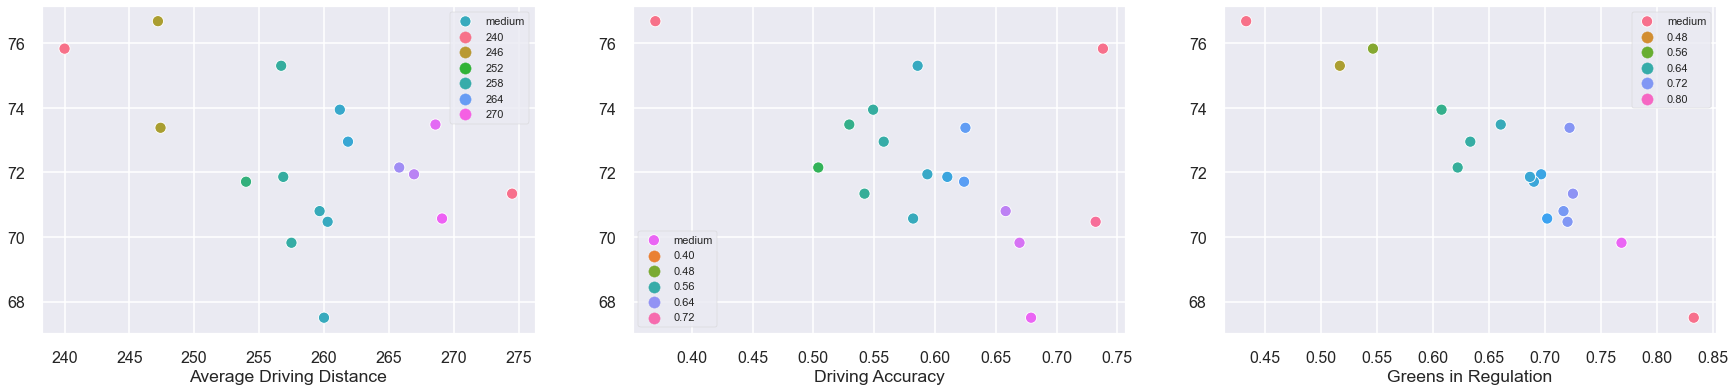

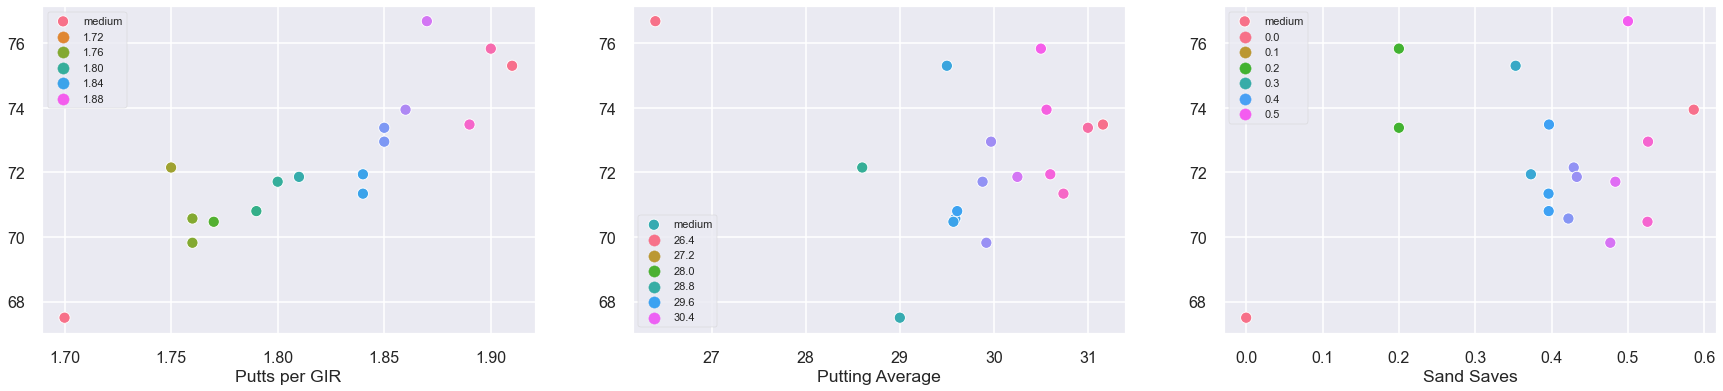

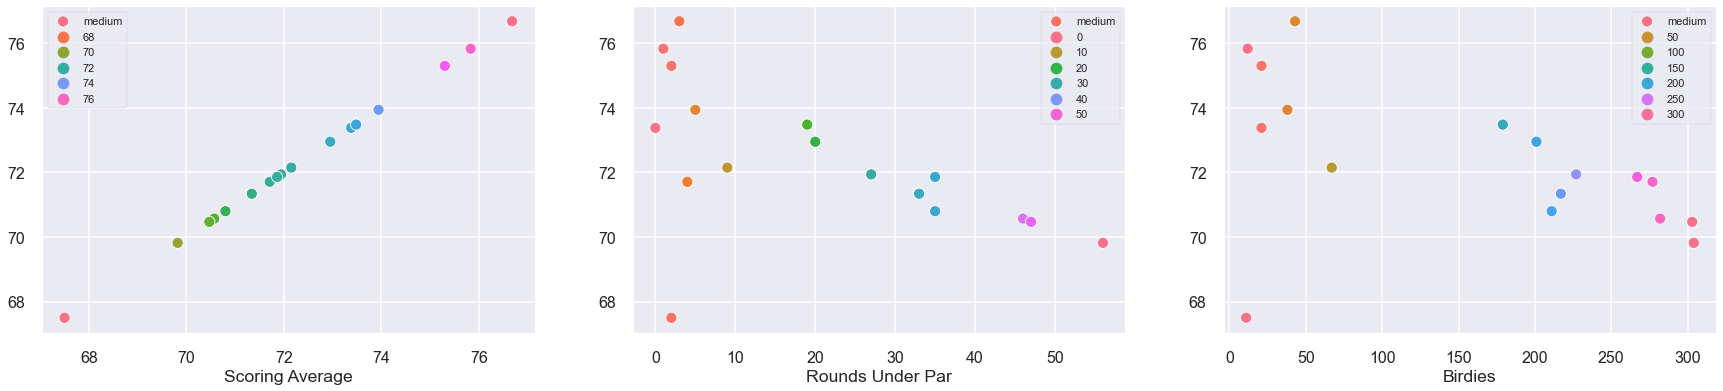

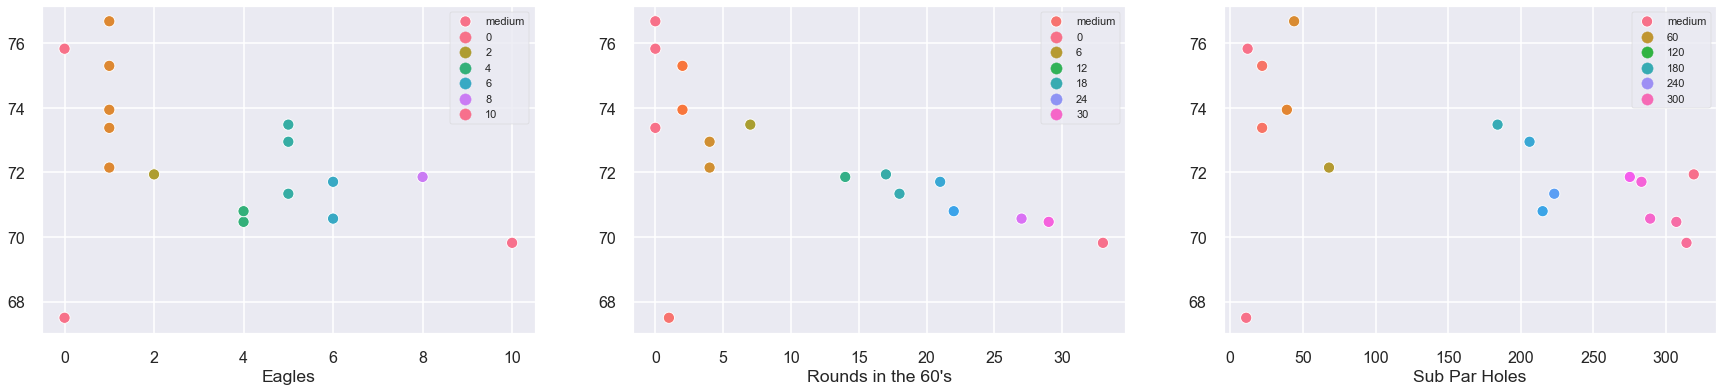

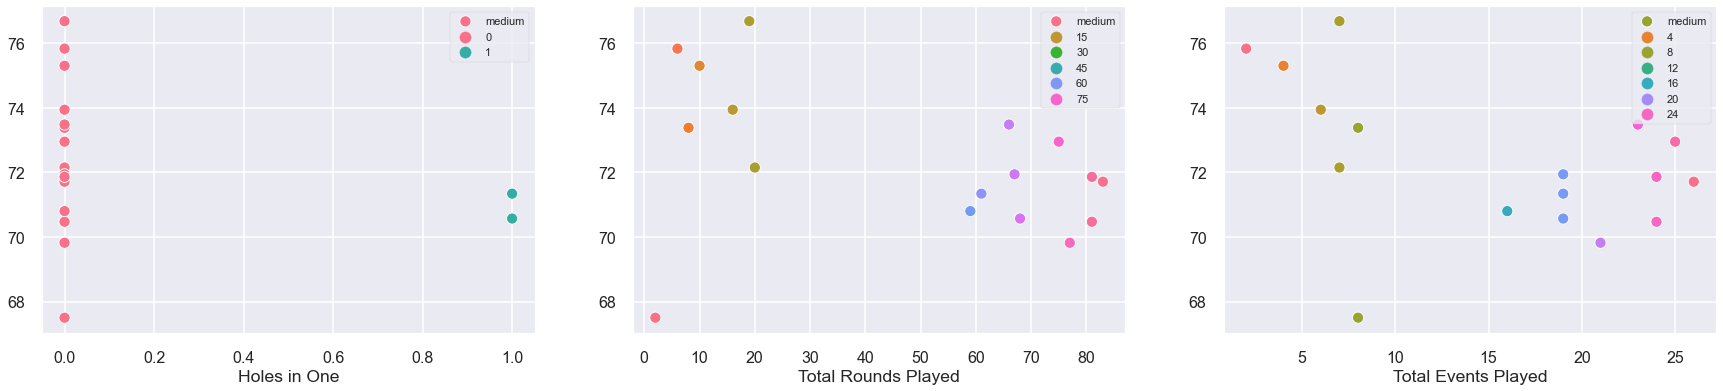

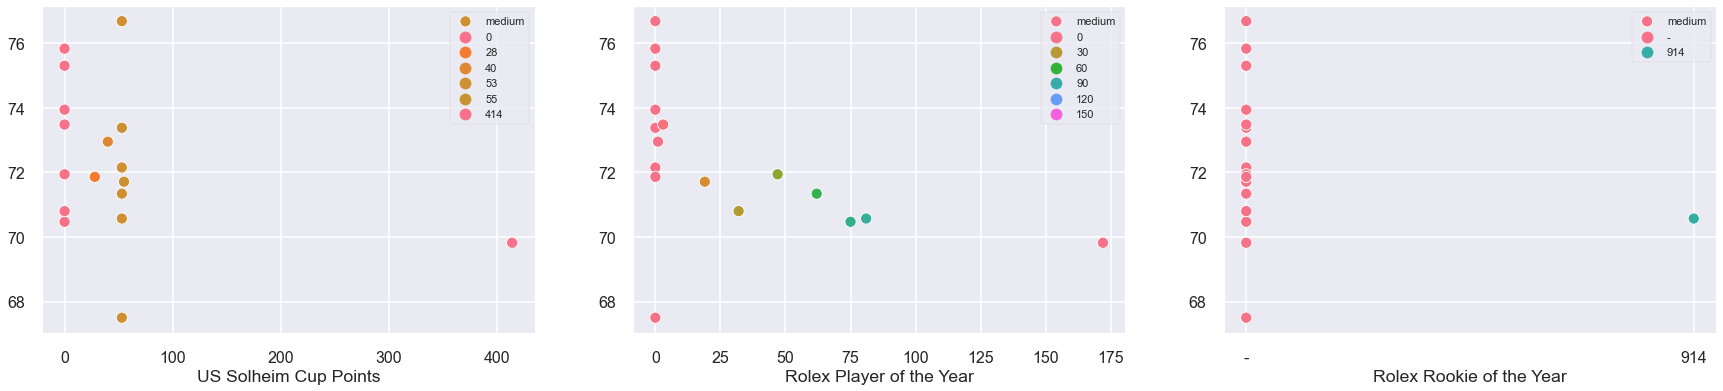

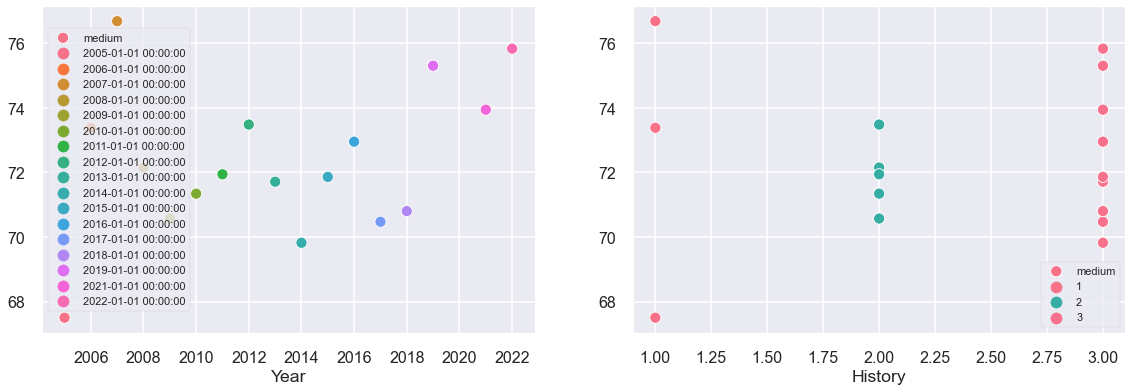

In [64]:
custom_scatter_plot(MW, 'Scoring Average', MW.columns, 3)

In [67]:
def reg_scatter(x, y, df):
    fig = plt.figure(figsize=(24, 7))
    sns.set(font_scale = 1.25)
    plt.style.use('seaborn-poster')
    plt.suptitle(f'{x} vs. {y}', size  = 20, color = 'black', ha = 'center')
    
    fig1 = fig.add_subplot(121); sns.scatterplot(MW[x], MW[y], data = df).set(xlim = (-50 + min(df[x]), (max(df[x] + 50))))
    fig2 = fig.add_subplot(122); sns.regplot(MW[x], MW[y], data = df, scatter_kws = {'color': 'g'}, line_kws = {'color': 'red'}).set(xlim = (-50 + min(df[x]), (max(df[x] + 50))))
    
    plt.show()

/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


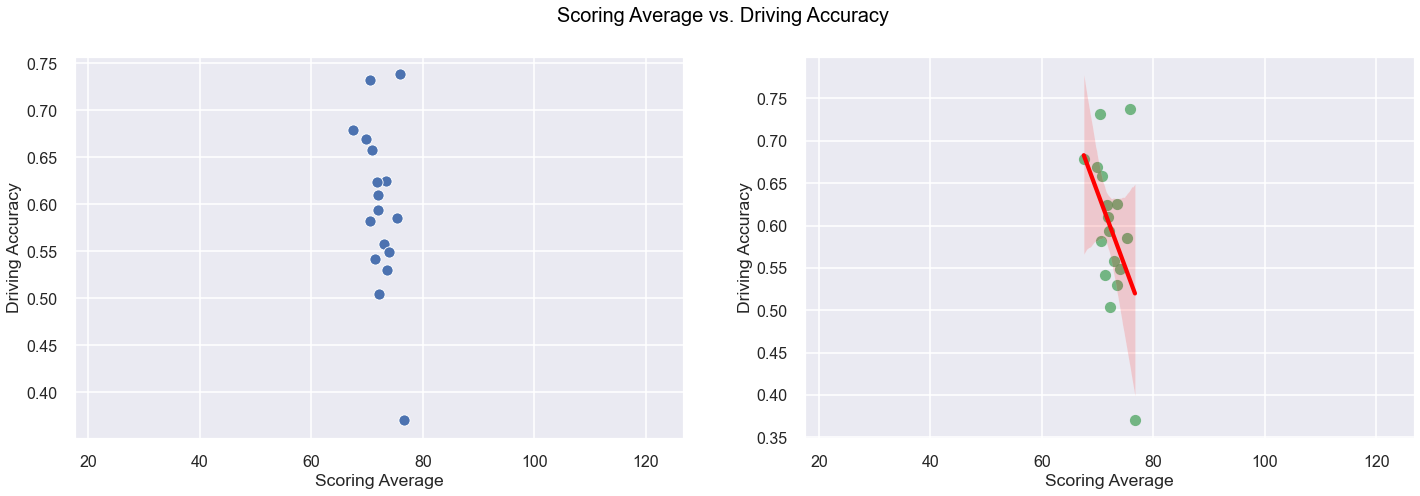

In [70]:
reg_scatter("Scoring Average", "Driving Accuracy", MW)

/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


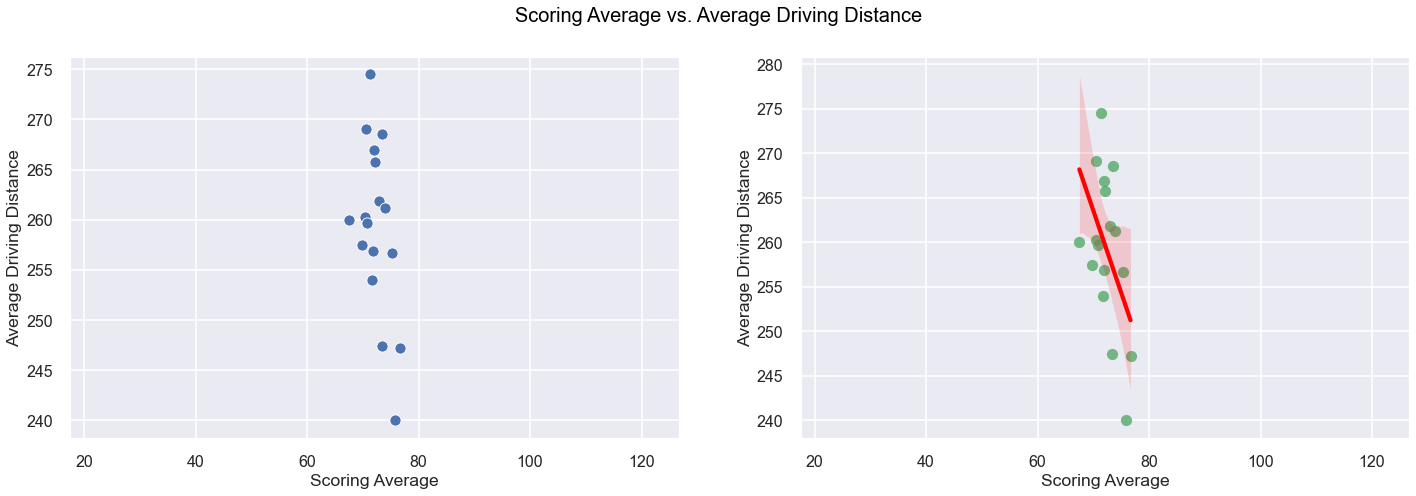

In [71]:
reg_scatter("Scoring Average", "Average Driving Distance", MW)

/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


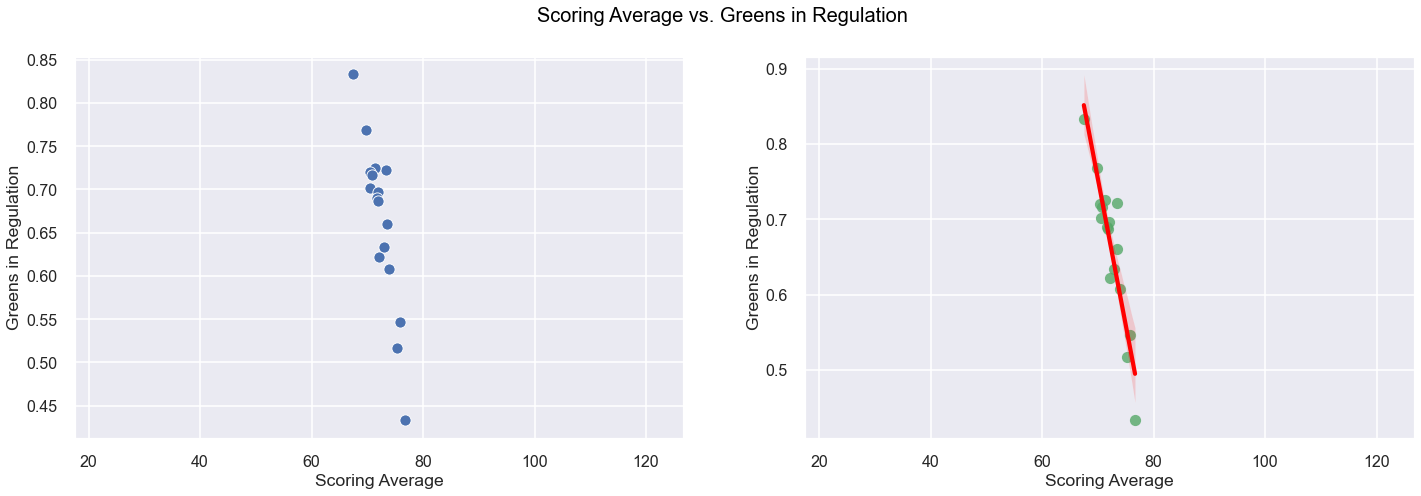

In [80]:
reg_scatter("Scoring Average", "Greens in Regulation", MW)

/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/tl164/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


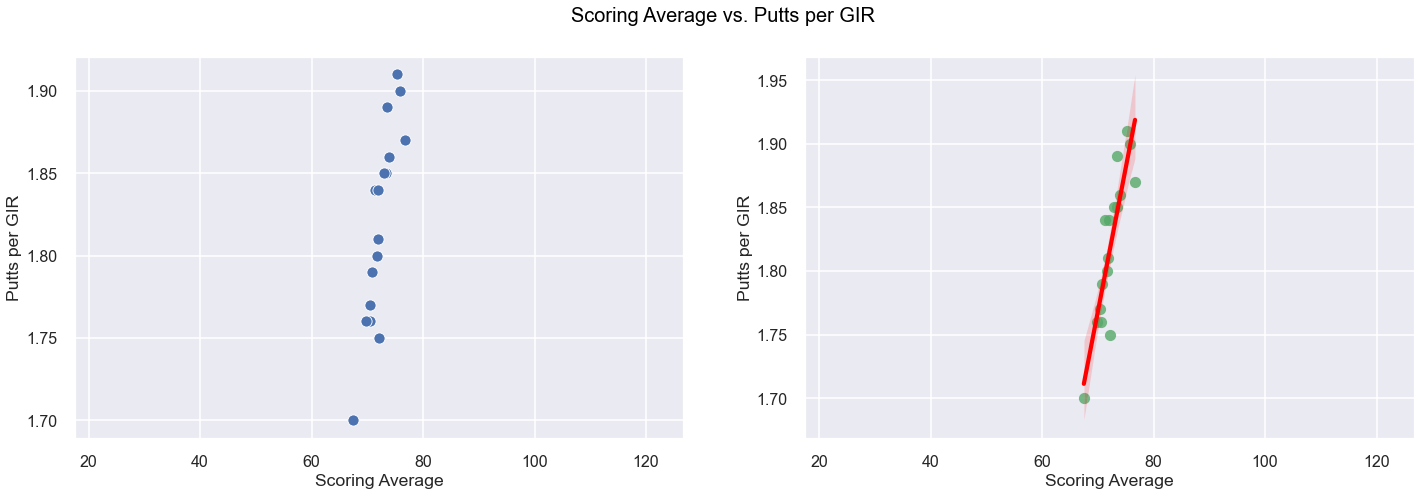

In [74]:
reg_scatter("Scoring Average", "Putts per GIR", MW)

## The data shows that green in regulation (GIR), driving accuracy and average driving distance have a negative correlation with Average Score. This is meaningful as player strives to increase their striking accuracy in an effort to decrease their average swing. Total rounds played and events attended have little to no correlation to the average score. This points to the fact that the more games you played, not necessarily , the better you will be from an average score persepctive. On the postivie correlation side, Putss per GIR is highly correlated to scoring average. This is because number of putts is part of scoring average's calucation. The more putts per GIR , the higher the average swings needed. Finally, all the other parameters show a weak or no correlation to scoring average at all.